# Random Forest Tuning (Descriptors + Fingerprints)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna

## Logging results

In [6]:
import pandas as pd

# Глобальный список для хранения всех результатов
all_results = []


def log_result(method_name, model_type, n_features, metrics, params=None, stage=None):
    """
    Сохраняет результаты в глобальную таблицу all_results.

    method_name — SHAP / MI / KBest / Lasso
    model_type — RF / OptunaRF / ExtraTrees / GBoost
    n_features — количество используемых фичей
    metrics — словарь метрик {"Accuracy":..., "F1":..., ...}
    params — словарь параметров модели
    stage — этап: baseline / final / optuna / simple_tuning
    """

    record = {
        "Method": method_name,
        "Model": model_type,
        "Stage": stage,
        "Top_Features": n_features,

        # Метрики
        "Accuracy": metrics.get("Accuracy"),
        "Precision": metrics.get("Precision"),
        "Recall": metrics.get("Recall"),
        "F1": metrics.get("F1"),
        "ROC_AUC": metrics.get("AUC"),
    }

    # Добавляем параметры модели, если есть
    if params is not None:
        for key, value in params.items():
            record[f"Param_{key}"] = value

    all_results.append(record)


def save_results_table(filename="all_results.xlsx"):
    """
    Преобразует global all_results → DataFrame и сохраняет таблицу.
    """
    df = pd.DataFrame(all_results)
    df.to_excel(filename, index=False)
    print(f"Saved full results table to {filename}")
    return df


## Molecule, Descriptor + Fingerprints and Outlier Functions

## Dataset Processing

In [7]:
import pandas as pd

# Имена файлов – те же, что у тебя уже есть
TRAIN_X_CSV = "in_chemico_homolumo_x_train.csv"
TEST_X_CSV  = "in_chemico_homolumo_x_test.csv"
TRAIN_Y_CSV = "in_chemico_homolumo_y_train.csv"
TEST_Y_CSV  = "in_chemico_homolumo_y_test.csv"

# Читаем признаки
X_train = pd.read_csv(TRAIN_X_CSV)
X_test  = pd.read_csv(TEST_X_CSV)

# Читаем таргеты (берём первый столбец как Series)
y_train = pd.read_csv(TRAIN_Y_CSV).iloc[:, 0]
y_test  = pd.read_csv(TEST_Y_CSV).iloc[:, 0]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (129, 1235)
X_test: (33, 1235)
y_train: (129,)
y_test: (33,)


In [8]:
X_train.shape[1]

1235

In [9]:
X_train.shape[0]

129

## Base Model Train

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.7741

Classification report:
              precision    recall  f1-score   support

           0      0.556     0.667     0.606        15
           1      0.667     0.556     0.606        18

    accuracy                          0.606        33
   macro avg      0.611     0.611     0.606        33
weighted avg      0.616     0.606     0.606        33



## Feature Selection

PermutationExplainer explainer: 130it [44:09, 20.54s/it]                         
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics

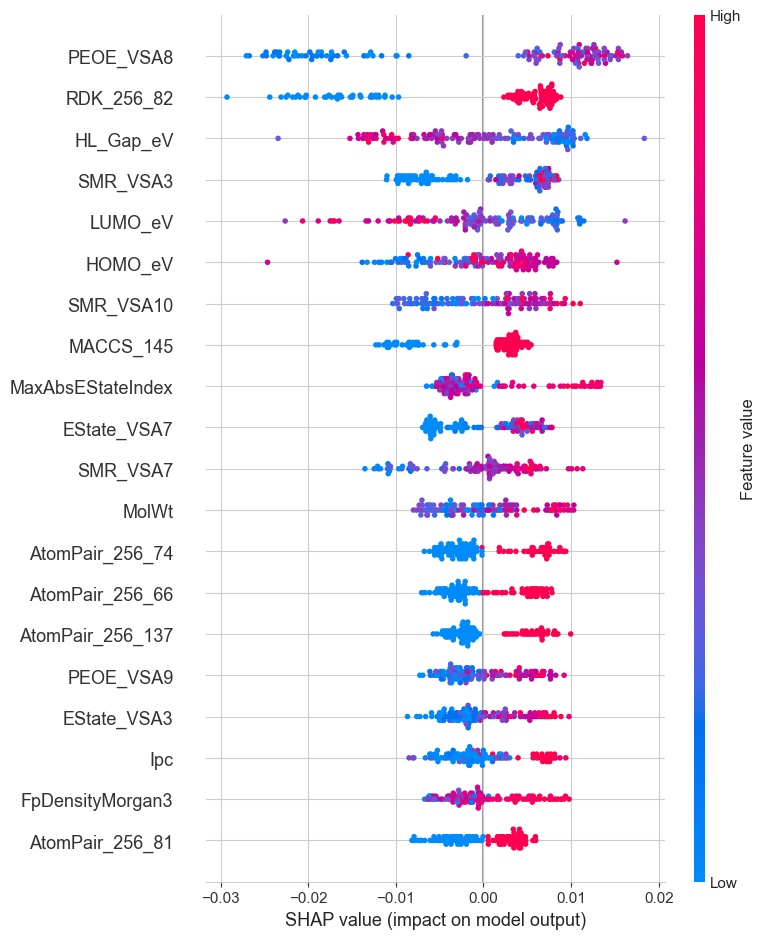


Top 10 SHAP features:
PEOE_VSA8            0.013587
RDK_256_82           0.009285
HL_Gap_eV            0.007170
SMR_VSA3             0.006077
LUMO_eV              0.005941
HOMO_eV              0.005083
SMR_VSA10            0.005004
MACCS_145            0.004649
MaxAbsEStateIndex    0.004632
EState_VSA7          0.004552

Top 10 MI features:
HL_Gap_eV         0.690711
HOMO_eV           0.690711
LUMO_eV           0.690711
BertzCT           0.679965
BCUT2D_CHGLO      0.679965
MolLogP           0.679965
BCUT2D_LOGPLOW    0.679965
BCUT2D_MWHI       0.679965
qed               0.679965
Kappa3            0.679965

Top 10 Permutation features:
MaxAbsEStateIndex    0.0
MinAbsEStateIndex    0.0
MinEStateIndex       0.0
qed                  0.0
SPS                  0.0
MolWt                0.0
MaxPartialCharge     0.0
MinPartialCharge     0.0
FpDensityMorgan1     0.0
FpDensityMorgan2     0.0

Top 10 Lasso features:
RDK_256_82          2.046792
Morgan2_256_241     1.638652
AtomPair_256_74     0.99

In [12]:
import shap
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# === 1. SHAP Importance ===
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# === 2. Mutual Information (MI) ===
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True, random_state=42)
mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# === 3. Permutation Importance (модельно-зависимый отбор) ===
perm = permutation_importance(base_model, X_train, y_train, n_repeats=10, random_state=42)
perm_features = pd.Series(perm.importances_mean, index=X_train.columns).sort_values(ascending=False)

# === 4. Lasso Logistic Regression (L1 коэф.) ===
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 5. Визуализация и вывод ===
shap.summary_plot(shap_values, X_train)

print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())

print("\nTop 10 MI features:")
print(mi_features.head(10).to_string())

print("\nTop 10 Permutation features:")
print(perm_features.head(10).to_string())

print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

## Evaluate Feature Method

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.767692  0.786108    0.838187
1       10     0.713538  0.730405    0.825733
2       15     0.752000  0.777052    0.844505
3       20     0.712923  0.734783    0.826877
4       25     0.728615  0.745752    0.834799
..     ...          ...       ...         ...
242   1215     0.698154  0.717882    0.798352
243   1220     0.690462  0.713771    0.797756
244   1225     0.698154  0.717760    0.798260
245   1230     0.698154  0.721056    0.794780
246   1235     0.690462  0.712062    0.794093

[247 rows x 4 columns]

Best N by CV F1 (SHAP): 5
Top_N          5.000000
CV_Accuracy    0.767692
CV_F1          0.786108
CV_ROC_AUC     0.838187
Name: 0, dtype: float64


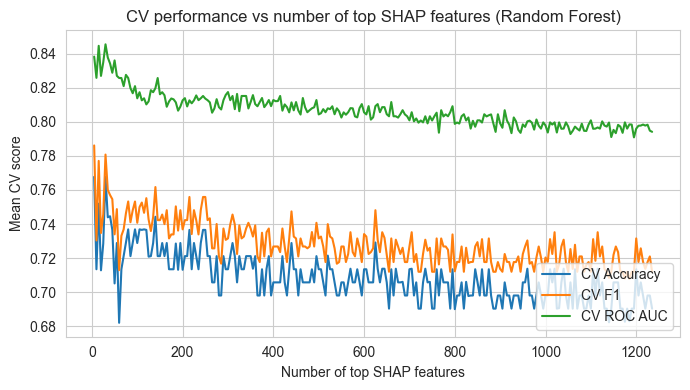


===== Evaluating MI feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.728923  0.760106    0.792262
1       10     0.674769  0.705032    0.782875
2       15     0.705231  0.736814    0.781639
3       20     0.713231  0.736253    0.767079
4       25     0.705538  0.727172    0.766209
..     ...          ...       ...         ...
242   1215     0.682769  0.708073    0.794780
243   1220     0.705846  0.723580    0.796566
244   1225     0.690462  0.712062    0.795971
245   1230     0.690462  0.717068    0.794780
246   1235     0.690462  0.712062    0.797253

[247 rows x 4 columns]

Best N by CV F1 (MI): 5
Top_N          5.000000
CV_Accuracy    0.728923
CV_F1          0.760106
CV_ROC_AUC     0.792262
Name: 0, dtype: float64


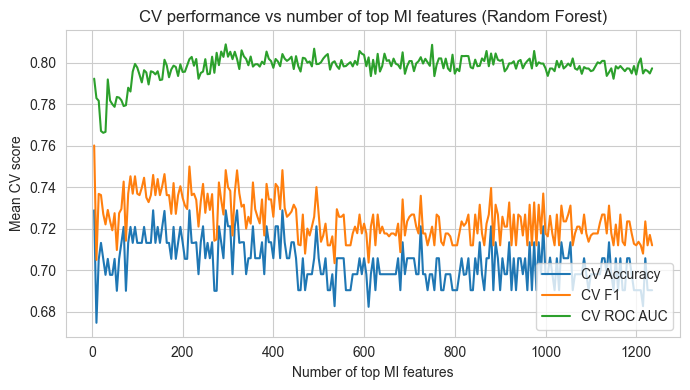


===== Evaluating PI feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.667077  0.670148    0.709982
1       10     0.674769  0.688193    0.749267
2       15     0.720923  0.731839    0.767033
3       20     0.690154  0.699438    0.766209
4       25     0.690462  0.705623    0.758059
..     ...          ...       ...         ...
242   1215     0.690462  0.712062    0.792399
243   1220     0.705846  0.722189    0.797253
244   1225     0.682769  0.708073    0.797253
245   1230     0.690462  0.713771    0.795879
246   1235     0.698154  0.717760    0.799634

[247 rows x 4 columns]

Best N by CV F1 (PI): 40
Top_N          40.000000
CV_Accuracy     0.736923
CV_F1           0.752070
CV_ROC_AUC      0.780678
Name: 7, dtype: float64


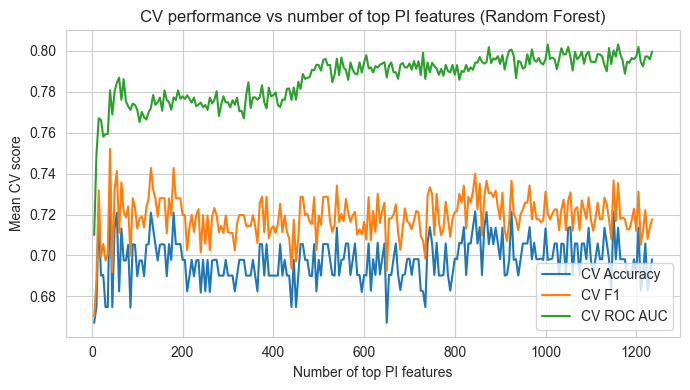


===== Evaluating Lasso feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.814769  0.828598    0.901007
1       10     0.844615  0.853968    0.936584
2       15     0.828923  0.837308    0.928984
3       20     0.891385  0.894911    0.950549
4       25     0.876000  0.880301    0.940842
..     ...          ...       ...         ...
242   1215     0.682769  0.708073    0.800137
243   1220     0.682462  0.707386    0.798947
244   1225     0.682769  0.706643    0.797253
245   1230     0.698154  0.717760    0.794551
246   1235     0.690462  0.713771    0.799634

[247 rows x 4 columns]

Best N by CV F1 (Lasso): 20
Top_N          20.000000
CV_Accuracy     0.891385
CV_F1           0.894911
CV_ROC_AUC      0.950549
Name: 3, dtype: float64


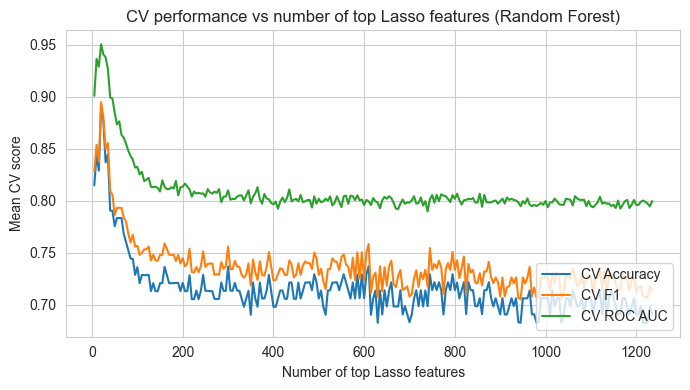

In [14]:
best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train)

best_mi, mi_cv_table = evaluate_rf_feature_method(
    "MI", mi_features, X_train, y_train)

best_perm, perm_cv_table = evaluate_rf_feature_method(
    "PI", perm_features, X_train, y_train)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train)

## Train Model Features

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=best_n,      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание
    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Baseline_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params={
        "n_estimators": X_train.shape[1],
        "class_weight": "balanced"
    },
    stage="final"
)


    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [16]:
final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_mi_model, mi_metrics = train_final_rf_model(
    "MI", mi_features, best_mi, X_train, X_test, y_train, y_test
)

final_perm_model, perm_metrics = train_final_rf_model(
    "PI", perm_features, best_perm, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 5 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.5758
Precision: 0.6111
Recall:    0.6111
F1 score:  0.6111
ROC AUC:   0.6574

===== FINAL Random Forest model using 5 MI features =====

Final model performance (MI) on TEST:
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7685

===== FINAL Random Forest model using 40 PI features =====

Final model performance (PI) on TEST:
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7259

===== FINAL Random Forest model using 20 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6364
Precision: 0.6500
Recall:    0.7222
F1 score:  0.6842
ROC AUC:   0.6741


## Model Feautures Tunning (Optuna)

In [17]:
def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    n_min = max(10, int(best_n * 0.5))
    n_max = max(n_min + 1, int(best_n * 1.25))

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", n_min, n_max),
            "max_depth": trial.suggest_int("max_depth", 4, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, None]),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1,
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(
            model, X_train_fs, y_train,
            cv=cv, scoring="f1", n_jobs=-1
        ).mean()

        return scores

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
        "Best_N": best_n,
        "Feature_Ranking": feature_ranking,
    }


## Model Feautures Tunning (Optuna + gboost)

In [18]:
from optuna import trial


def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                             X_train, X_test, y_train, y_test, n_trials=50):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)


    n_min = max(10, int(best_n * 0.5))
    n_max = max(n_min + 1, int(best_n * 1.25))

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", n_min, n_max),
            "max_depth": trial.suggest_int("max_depth", 4, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, None]),
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15),
            }

        model = GradientBoostingClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="f1",
            n_jobs=-1
        ).mean()

        return scores

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = GradientBoostingClassifier(random_state=42, **best_params)
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
        "Best_N": best_n,
        "Feature_Ranking": feature_ranking,
    }

## Result

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

methods = {
    "SHAP": (shap_features, best_shap),
    "MI": (mi_features, best_mi),
    "PI": (perm_features, best_perm),
    "Lasso": (lasso_features, best_lasso),
}

rf_rows = []
for name, (ranking, best_n) in methods.items():
    rf_rows.append(
        tune_rf_optuna(name, ranking, best_n,
                       X_train, X_test, y_train, y_test)
    )

rf_results_df = pd.DataFrame(rf_rows)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
rf_results_df

,Method,Accuracy,AUC,Precision,Recall,F1,Params,Best_N,Feature_Ranking
0,SHAP,0.606061,0.629630,0.647059,0.611111,0.628571,"{'n_estimators': 11, 'max_depth': 12, 'min_sam...",5,PEOE_VSA8 0.013587 RDK_256_82 ...
1,MI,0.818182,0.827778,0.875000,0.777778,0.823529,"{'n_estimators': 10, 'max_depth': 7, 'min_samp...",5,HL_Gap_eV 6.907115e-01 HOMO_eV ...
2,PI,0.515152,0.611111,0.555556,0.555556,0.555556,"{'n_estimators': 47, 'max_depth': 7, 'min_samp...",40,MaxAbsEStateIndex 0.0 MinAbsEStateIndex ...
3,Lasso,0.545455,0.646296,0.578947,0.611111,0.594595,"{'n_estimators': 16, 'max_depth': 7, 'min_samp...",20,RDK_256_82 2.046792 Morgan2_256_241 ...


In [21]:
best_rf_row = rf_results_df.loc[rf_results_df["AUC"].idxmax()]
rf_best_params = best_rf_row["Params"]
rf_best_n = best_rf_row["Best_N"]
rf_best_method = best_rf_row["Method"]

print("Best RF:", rf_best_method, rf_best_n, rf_best_params)

Best RF: MI 5 {'n_estimators': 10, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


## Dinamic


=== Testing top 5 SHAP features ===
CV Accuracy (mean over folds): 0.768

Best k by CV Accuracy: k = 5, CV_Acc = 0.768


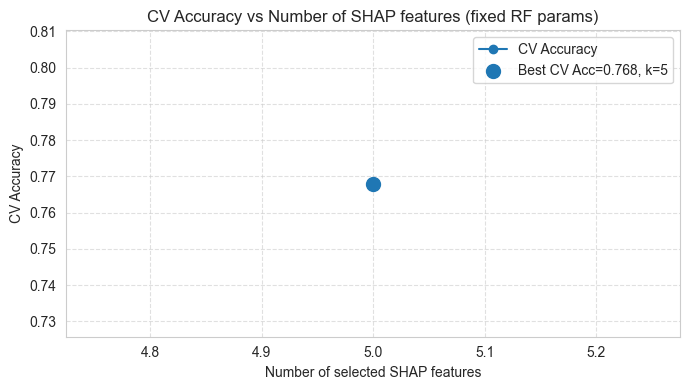


=== Final evaluation on TEST with best k from CV ===
RF best_params_shap: {'n_estimators': 11, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
TEST Accuracy: 0.606 | TEST ROC-AUC: 0.630


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance
shap_row = rf_results_df[rf_results_df["Method"] == "SHAP"].iloc[0]
best_params_shap = shap_row["Params"]

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sweep по числу признаков (ТОЛЬКО CV, без теста!)
for k in range(5, best_shap + 1, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        **best_params_shap,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    # CV-оценка (accuracy, можно заменить на 'f1')
    scores = cross_val_score(
        rf_clf,
        X_train_sel,
        y_train,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    acc = scores.mean()
    results.append((k, acc))
    print(f"CV Accuracy (mean over folds): {acc:.3f}")

# Анализ результатов по CV
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_cv_acc = accuracies[best_index]

print(f"\nBest k by CV Accuracy: k = {best_k}, CV_Acc = {best_cv_acc:.3f}")

# График по CV
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='CV Accuracy')
plt.scatter(best_k, best_cv_acc, s=100, zorder=5,
            label=f'Best CV Acc={best_cv_acc:.3f}, k={best_k}')
plt.title('CV Accuracy vs Number of SHAP features (fixed RF params)')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('CV Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# ===== Финальная оценка на TEST (один раз!) =====
print("\n=== Final evaluation on TEST with best k from CV ===")

top_feats_final = ranking.head(best_k).index.tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

final_model = RandomForestClassifier(
    **best_params_shap,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_best, y_train)

y_pred = final_model.predict(X_test_best)
y_prob = final_model.predict_proba(X_test_best)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"RF best_params_shap: {best_params_shap}")
print(f"TEST Accuracy: {test_acc:.3f} | TEST ROC-AUC: {test_auc:.3f}")

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score


def sweep_k_features_with_fixed_rf(
    method_name,
    feature_ranking,      # pd.Series: feature -> importance (SHAP/MI/...)
    best_n_method,        # напр. best_shap
    best_params,          # dict из tune_rf_optuna: study.best_params
    X_train,
    X_test,
    y_train,
    y_test,
    k_min=5,
    scoring="accuracy",
    plot=True,
):

    print(f"\n=== sweep_k_features_with_fixed_rf for {method_name} ===")

    ranking = feature_ranking
    max_k = int(best_n_method)

    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Sweep по числу признаков (ТОЛЬКО CV, без теста!)
    for k in range(k_min, max_k + 1):
        print(f"\n--- Testing top {k} {method_name} features (CV only) ---")

        # Выбор top-k фичей
        top_feats = ranking.head(k).index.tolist()
        X_train_sel = X_train[top_feats]

        # Модель с уже найденными лучшими параметрами
        rf_clf = RandomForestClassifier(
            **best_params,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

        # CV-оценка
        scores = cross_val_score(
            rf_clf,
            X_train_sel,
            y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = scores.mean()
        results.append((k, mean_score))

        print(f"CV {scoring} (mean over folds): {mean_score:.3f}")

    # Анализ результатов по CV
    results = np.array(results)
    feature_counts = results[:, 0]
    cv_scores = results[:, 1]

    best_index = np.argmax(cv_scores)
    best_k = int(feature_counts[best_index])
    best_cv_score = cv_scores[best_index]

    print(f"\nBest k by CV {scoring}: k = {best_k}, CV_{scoring} = {best_cv_score:.3f}")

    # График по CV
    if plot:
        plt.figure(figsize=(7, 4))
        plt.plot(feature_counts, cv_scores, 'o-', label=f'CV {scoring}')
        plt.scatter(best_k, best_cv_score, s=100, zorder=5,
                    label=f'Best CV {scoring}={best_cv_score:.3f}, k={best_k}')
        plt.title(f'CV {scoring} vs Number of {method_name} features (fixed RF params)')
        plt.xlabel(f'Number of selected {method_name} features')
        plt.ylabel(f'CV {scoring}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ===== Финальная оценка на TEST (один раз!) =====
    print("\n=== Final evaluation on TEST with best k from CV ===")

    top_feats_final = ranking.head(best_k).index.tolist()
    X_train_best = X_train[top_feats_final]
    X_test_best = X_test[top_feats_final]

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_best, y_train)

    y_pred = final_model.predict(X_test_best)
    y_prob = final_model.predict_proba(X_test_best)[:, 1]

    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_prob)

    print(f"RF best_params ({method_name}): {best_params}")
    print(f"TEST Accuracy: {test_acc:.3f} | TEST ROC-AUC: {test_auc:.3f}")

    return {
        "method": method_name,
        "best_k": best_k,
        "best_cv_score": best_cv_score,
        "cv_scoring": scoring,
        "test_accuracy": test_acc,
        "test_auc": test_auc,
        "best_params": best_params,
        "cv_curve": (feature_counts, cv_scores),
        "top_features": top_feats_final,
        "final_model": final_model,
    }


=== sweep_k_features_with_fixed_rf for SHAP ===

--- Testing top 5 SHAP features (CV only) ---
CV f1 (mean over folds): 0.783

Best k by CV f1: k = 5, CV_f1 = 0.783


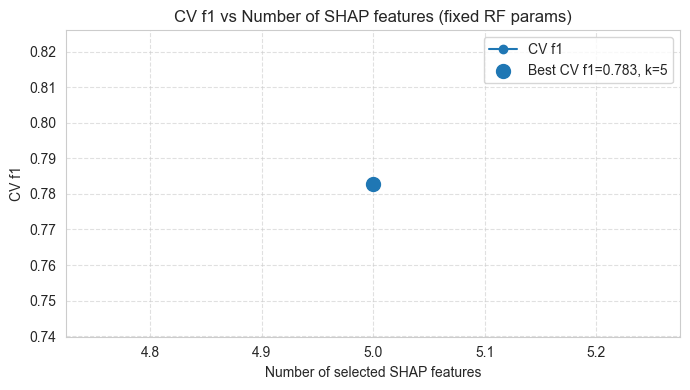


=== Final evaluation on TEST with best k from CV ===
RF best_params (SHAP): {'n_estimators': 11, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
TEST Accuracy: 0.606 | TEST ROC-AUC: 0.630


In [32]:
# достаём best_params для SHAP из rf_results_df
shap_row = rf_results_df[rf_results_df["Method"] == "SHAP"].iloc[0]
best_params_shap = shap_row["Params"]
best_shap = shap_row["Best_N"]      # или уже имеешь отдельно

res_shap = sweep_k_features_with_fixed_rf(
    method_name="SHAP",
    feature_ranking=shap_features,
    best_n_method=best_shap,
    best_params=best_params_shap,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)


=== sweep_k_features_with_fixed_rf for MI ===

--- Testing top 5 MI features (CV only) ---
CV f1 (mean over folds): 0.775

Best k by CV f1: k = 5, CV_f1 = 0.775


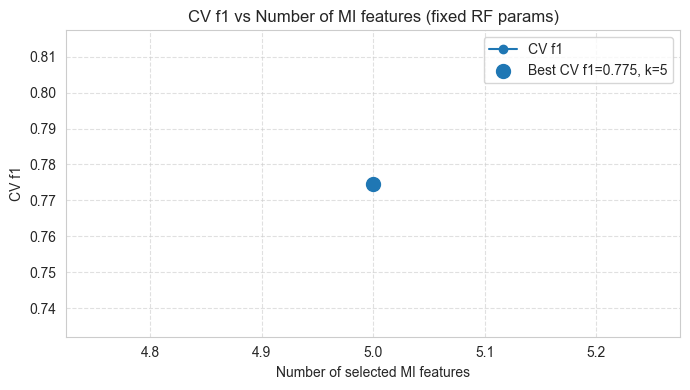


=== Final evaluation on TEST with best k from CV ===
RF best_params (MI): {'n_estimators': 10, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
TEST Accuracy: 0.818 | TEST ROC-AUC: 0.828


In [25]:
# достаём best_params для SHAP из rf_results_df
mi_row = rf_results_df[rf_results_df["Method"] == "MI"].iloc[0]
best_params_mi = mi_row["Params"]
best_mi = mi_row["Best_N"]      # или уже имеешь отдельно

res_mi = sweep_k_features_with_fixed_rf(
    method_name="MI",
    feature_ranking=mi_features,
    best_n_method=best_mi,
    best_params=best_params_mi,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)


=== sweep_k_features_with_fixed_rf for PI ===

--- Testing top 5 PI features (CV only) ---
CV f1 (mean over folds): 0.640

--- Testing top 6 PI features (CV only) ---
CV f1 (mean over folds): 0.671

--- Testing top 7 PI features (CV only) ---
CV f1 (mean over folds): 0.677

--- Testing top 8 PI features (CV only) ---
CV f1 (mean over folds): 0.706

--- Testing top 9 PI features (CV only) ---
CV f1 (mean over folds): 0.679

--- Testing top 10 PI features (CV only) ---
CV f1 (mean over folds): 0.698

--- Testing top 11 PI features (CV only) ---
CV f1 (mean over folds): 0.719

--- Testing top 12 PI features (CV only) ---
CV f1 (mean over folds): 0.714

--- Testing top 13 PI features (CV only) ---
CV f1 (mean over folds): 0.685

--- Testing top 14 PI features (CV only) ---
CV f1 (mean over folds): 0.682

--- Testing top 15 PI features (CV only) ---
CV f1 (mean over folds): 0.680

--- Testing top 16 PI features (CV only) ---
CV f1 (mean over folds): 0.687

--- Testing top 17 PI features (C

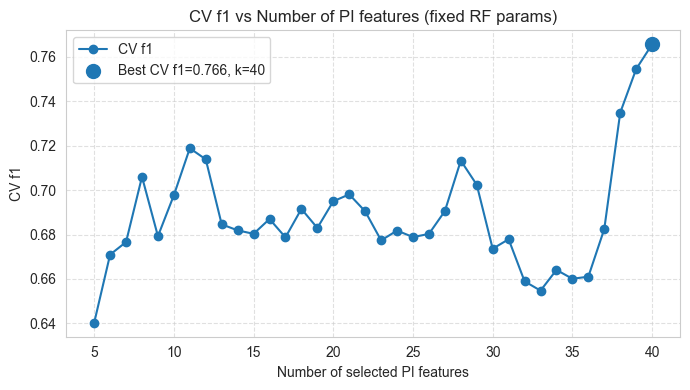


=== Final evaluation on TEST with best k from CV ===
RF best_params (PI): {'n_estimators': 47, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
TEST Accuracy: 0.515 | TEST ROC-AUC: 0.611


In [26]:
# достаём best_params для SHAP из rf_results_df
perm_row = rf_results_df[rf_results_df["Method"] == "PI"].iloc[0]
best_params_perm = perm_row["Params"]
best_perm = perm_row["Best_N"]      # или уже имеешь отдельно

res_perm = sweep_k_features_with_fixed_rf(
    method_name="PI",
    feature_ranking=perm_features,
    best_n_method=best_perm,
    best_params=best_params_perm,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)


=== sweep_k_features_with_fixed_rf for Lasso ===

--- Testing top 5 Lasso features (CV only) ---
CV f1 (mean over folds): 0.837

--- Testing top 6 Lasso features (CV only) ---
CV f1 (mean over folds): 0.759

--- Testing top 7 Lasso features (CV only) ---
CV f1 (mean over folds): 0.832

--- Testing top 8 Lasso features (CV only) ---
CV f1 (mean over folds): 0.854

--- Testing top 9 Lasso features (CV only) ---
CV f1 (mean over folds): 0.855

--- Testing top 10 Lasso features (CV only) ---
CV f1 (mean over folds): 0.866

--- Testing top 11 Lasso features (CV only) ---
CV f1 (mean over folds): 0.836

--- Testing top 12 Lasso features (CV only) ---
CV f1 (mean over folds): 0.825

--- Testing top 13 Lasso features (CV only) ---
CV f1 (mean over folds): 0.836

--- Testing top 14 Lasso features (CV only) ---
CV f1 (mean over folds): 0.814

--- Testing top 15 Lasso features (CV only) ---
CV f1 (mean over folds): 0.838

--- Testing top 16 Lasso features (CV only) ---
CV f1 (mean over folds): 0

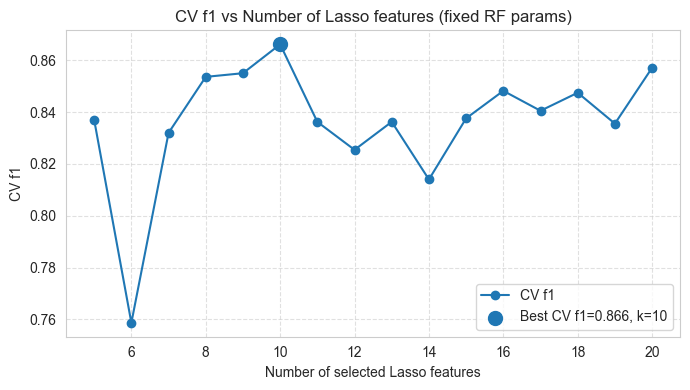


=== Final evaluation on TEST with best k from CV ===
RF best_params (Lasso): {'n_estimators': 16, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5}
TEST Accuracy: 0.515 | TEST ROC-AUC: 0.544


In [27]:
# достаём best_params для SHAP из rf_results_df
lasso_row = rf_results_df[rf_results_df["Method"] == "Lasso"].iloc[0]
best_params_lasso = lasso_row["Params"]
best_lasso = lasso_row["Best_N"]

res_lasso = sweep_k_features_with_fixed_rf(
    method_name="Lasso",
    feature_ranking=lasso_features,
    best_n_method=best_lasso,
    best_params=best_params_lasso,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)

In [28]:
import pandas as pd

# 1. rf_results_df уже есть (результаты Optuna)
# Колонки: ["Method", "AUC", "Accuracy", "Precision", "Recall", "F1", "Params", "Best_N", "Feature_Ranking"]

# 2. Предположим, ты вызывала sweep-функцию так:
# res_shap  = sweep_k_features_with_fixed_rf(...)
# res_mi    = sweep_k_features_with_fixed_rf(...)
# res_pi    = sweep_k_features_with_fixed_rf(...)
# res_lasso = sweep_k_features_with_fixed_rf(...)

sweep_rows = []

for res in [res_shap, res_mi, res_perm, res_lasso]:
    sweep_rows.append({
        "Method":      res["method"],
        "CV_metric":   res["cv_scoring"],          # "f1" или "accuracy"
        "CV_best_k":   res["best_k"],
        "CV_best_val": res["best_cv_score"],
        "TEST_AUC":    res["test_auc"],
        "TEST_Acc":    res["test_accuracy"],
        "Params":      res["best_params"],
    })

sweep_df = pd.DataFrame(sweep_rows)

# 3. Сохранение в CSV: отдельно и вместе

rf_results_df.to_csv("rf_results_optuna.csv", index=False, encoding="utf-8")
sweep_df.to_csv("rf_results_sweep_k.csv", index=False, encoding="utf-8")

# 4. Совместная таблица для удобного сравнения

# Переименуем колонки в rf_results_df, чтобы было понятно, что это Optuna
rf_optuna_view = rf_results_df[["Method", "AUC", "Accuracy", "Precision", "Recall", "F1", "Best_N", "Params"]].copy()
rf_optuna_view = rf_optuna_view.rename(columns={
    "AUC": "Optuna_AUC",
    "Accuracy": "Optuna_Acc",
    "Precision": "Optuna_Precision",
    "Recall": "Optuna_Recall",
    "F1": "Optuna_F1",
    "Best_N": "Optuna_k",
})

# Объединим по колонке Method
combined_df = rf_optuna_view.merge(sweep_df, on="Method", how="left")

combined_df.to_csv("rf_results_optuna_vs_sweep.csv", index=False, encoding="utf-8")

print("Saved:")
print(" - rf_results_optuna.csv")
print(" - rf_results_sweep_k.csv")
print(" - rf_results_optuna_vs_sweep.csv")
print("\nCombined view:")
print(combined_df.head().to_string(index=False))


Saved:
 - rf_results_optuna.csv
 - rf_results_sweep_k.csv
 - rf_results_optuna_vs_sweep.csv

Combined view:
Method  Optuna_AUC  Optuna_Acc  Optuna_Precision  Optuna_Recall  Optuna_F1  Optuna_k                                                                                                     Params_x CV_metric  CV_best_k  CV_best_val  TEST_AUC  TEST_Acc                                                                                                     Params_y
  SHAP    0.629630    0.606061          0.647059       0.611111   0.628571         5 {'n_estimators': 11, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}        f1          5     0.782896  0.629630  0.606061 {'n_estimators': 11, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
    MI    0.827778    0.818182          0.875000       0.777778   0.823529         5  {'n_estimators': 10, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_fea

In [29]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


def find_best_threshold_cv(model, X_train, y_train,
                           metric="f1", n_splits=5):
    """
    Подбор оптимального порога по k-fold CV на train.
    metric: "f1" или "accuracy".
    Возвращает лучший порог и среднее значение метрики по CV.
    """

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = np.linspace(0.1, 0.9, 81)   # шаг 0.01

    best_thr = 0.5
    best_score = -np.inf

    for thr in thresholds:
        fold_scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # обучаем копию модели на фолде
            mdl = clone(model)
            mdl.fit(X_tr, y_tr)

            proba = mdl.predict_proba(X_val)[:, 1]
            preds = (proba >= thr).astype(int)

            if metric == "accuracy":
                s = accuracy_score(y_val, preds)
            else:
                s = f1_score(y_val, preds)

            fold_scores.append(s)

        mean_score = np.mean(fold_scores)
        if mean_score > best_score:
            best_score = mean_score
            best_thr = thr

    return best_thr, best_score


In [82]:
from sklearn.base import clone

# Допустим, у тебя есть:
# best_params_mi, mi_best_k, mi_features (pd.Index топ-фич), X_train, X_test, y_train, y_test

X_train_mi = X_train[mi_features]
X_test_mi = X_test[mi_features]

base_rf_mi = RandomForestClassifier(
    **best_params_mi,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
base_rf_mi.fit(X_train_mi, y_train)

# Подбор порога по CV
best_thr_mi, best_cv_f1_mi = find_best_threshold_cv(
    base_rf_mi, X_train_mi, y_train,
    metric="f1", n_splits=5
)
print(f"Best threshold (MI RF) by CV F1: thr={best_thr_mi:.2f}, CV_F1={best_cv_f1_mi:.3f}")

# Оценка на тесте с этим порогом
proba_test = base_rf_mi.predict_proba(X_test_mi)[:, 1]
y_pred_thr = (proba_test >= best_thr_mi).astype(int)

acc = accuracy_score(y_test, y_pred_thr)
f1 = f1_score(y_test, y_pred_thr)
auc = roc_auc_score(y_test, proba_test)

print(f"TEST with tuned threshold (MI RF): Acc={acc:.3f}, F1={f1:.3f}, AUC={auc:.3f}")


KeyError: "None of [Index([    0.6799649864418517,     0.6799649864418517,     0.6799649864418515,\n            0.662528237771501,     0.6544158634495699,     0.6469641446655823,\n           0.6320374345862244,      0.630513671518613,     0.6063006035555544,\n           0.5971386258425986,\n       ...\n       0.00011678554903099547, 0.00011678554903099547,  8.819842023660707e-05,\n        8.651617749971807e-05,   6.70886269940052e-05, 5.4810596432142145e-05,\n        2.245680911583392e-05, 1.7375935689234456e-05,  2.587820769173188e-06,\n                          0.0],\n      dtype='float64', length=974)] are in the [columns]"

# XSMILES


In [36]:
import io
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from explain import _explain_by_groups, explain_atom_importance

from explain import _explain_by_groups, explain_atom_importance
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import io
import numpy as np
import matplotlib.pyplot as plt


# =========================
# 1. ЧИСТАЯ descriptor_fn
# =========================
def make_descriptor_fn(train_medians, iqr_limits, numeric_cols, trained_columns):

    def descriptor_fn(mol):
        if mol is None:
            raise ValueError("descriptor_fn: got None mol")

        # RAW descriptors
        desc = calculate_descriptors(mol)
        fp   = calculate_maccs_fingerprint(mol)
        row = {**desc, **fp}
        df = pd.DataFrame([row])

        # restore only known columns
        df = df.reindex(columns=train_medians.index, fill_value=np.nan)

        # fill NaNs
        df = df.fillna(train_medians)

        # 3. IQR only on numeric (SAFE)
        for col in numeric_cols:
            if col in df.columns and col in iqr_limits:
                low, high = iqr_limits[col]
                df[col] = np.clip(df[col], low, high)


        # keep only trained columns
        df_final = df.reindex(columns=trained_columns, fill_value=0)

        assert list(df_final.columns) == list(trained_columns), \
            "Feature misalignment!"

        return df_final.to_numpy()[0]

    return descriptor_fn



def explain_smarts_groups(model, mol, descriptor_fn, groups, normalize=True):
    atts, base = _explain_by_groups(model, mol, descriptor_fn, groups)
    if normalize and atts.std() > 0:
        atts = (atts - atts.mean()) / atts.std()
    return atts, base, groups

def tokenize_smiles(smiles: str):
    tokens = []
    i = 0
    while i < len(smiles):
        if i + 1 < len(smiles) and smiles[i:i+2] in ["Cl", "Br"]:
            tokens.append(smiles[i:i+2])
            i += 2
            continue
        if smiles[i] == "[":
            j = i + 1
            while j < len(smiles) and smiles[j] != "]":
                j += 1
            tokens.append(smiles[i:j+1])
            i = j + 1
            continue
        tokens.append(smiles[i])
        i += 1

    return tokens

def tokens_to_groups(tokens, mol):
    groups = []
    atom_counter = 0
    n_atoms = mol.GetNumAtoms()

    for tok in tokens:
        if tok.startswith("[") or tok in ["Cl", "Br"] or tok.isalpha():
            if atom_counter < n_atoms:
                groups.append([atom_counter])
                atom_counter += 1
            else:
                groups.append([])
        else:
            groups.append([])
    return groups



def compute_token_importance(model, mol, descriptor_fn, tokens):
    groups = tokens_to_groups(tokens, mol)
    scores, base, _ = explain_smarts_groups(model, mol, descriptor_fn, groups)
    return scores, base

def xsmiles_visualize(mol, atom_scores, smiles_scores, tokens):
    import numpy as np
    import matplotlib.pyplot as plt
    import io
    from rdkit.Chem import rdDepictor
    from rdkit.Chem.Draw import rdMolDraw2D

    assert len(tokens) == len(smiles_scores), \
        f"Tokens={len(tokens)} but scores={len(smiles_scores)}"

    # 1. Atom-level highlighting (XSMILES style)
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 400)
    rdDepictor.Compute2DCoords(mol)
    max_abs = max(abs(atom_scores))
    atom_colors = {}
    for i, score in enumerate(atom_scores):

        alpha = min(1.0, abs(score) / max_abs)

        if score >= 0:
            atom_colors[i] = (0.6, 0.0, 0.6, alpha)      # purple
        else:
            atom_colors[i] = (0.0, 0.5, 1.0, alpha)      # cyan
    drawer.DrawMolecule(
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()

    # 2. SMILES token barplot (purple = positive, cyan = negative)
    plt.figure(figsize=(16, 8))
    # Molecule
    plt.subplot(2, 1, 1)
    plt.imshow(plt.imread(io.BytesIO(png)))
    plt.axis("off")
    # Token importance bars
    plt.subplot(2, 1, 2)
    x = np.arange(len(tokens))
    # цвета для каждого токена
    bar_colors = [
        (0.6, 0.0, 0.6) if s >= 0 else (0.0, 0.5, 1.0)
        for s in smiles_scores
    ]
    plt.bar(x, smiles_scores, color=bar_colors)
    # горизонтальные подписи
    plt.xticks(x, tokens, rotation=0, fontsize=9)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.tight_layout()
    plt.show()



def run_xsmiles_pipeline(
    model,
    smiles,
    train_medians,
    iqr_limits,
    numeric_cols,
    trained_columns
):

    # Create descriptor_fn with closure
    descriptor = make_descriptor_fn(train_medians, iqr_limits, numeric_cols, trained_columns)

    # RDKit mol
    mol, status = molecule_from_smiles(smiles)
    if mol is None:
        raise ValueError(f"SMILES parsing failed: {status}")

    # Atom importance
    atom_scores, base_atom = explain_atom_importance(
        model=model,
        mol=mol,
        descriptor_fn=descriptor,
        normalize=True
    )

    # Token importance
    smiles_canonical = Chem.MolToSmiles(mol, canonical=True)
    tokens = tokenize_smiles(smiles_canonical)
    token_scores, base_token = compute_token_importance(
        model=model,
        mol=mol,
        descriptor_fn=descriptor,
        tokens=tokens
    )

    # Visualization
    xsmiles_visualize(mol, atom_scores, token_scores, tokens)

    return {
        "smiles": smiles,
        "tokens": tokens,
        "atom_scores": atom_scores,
        "token_scores": token_scores,
        "base_atom_pred": float(base_atom),
        "base_token_pred": float(base_token)
    }



C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


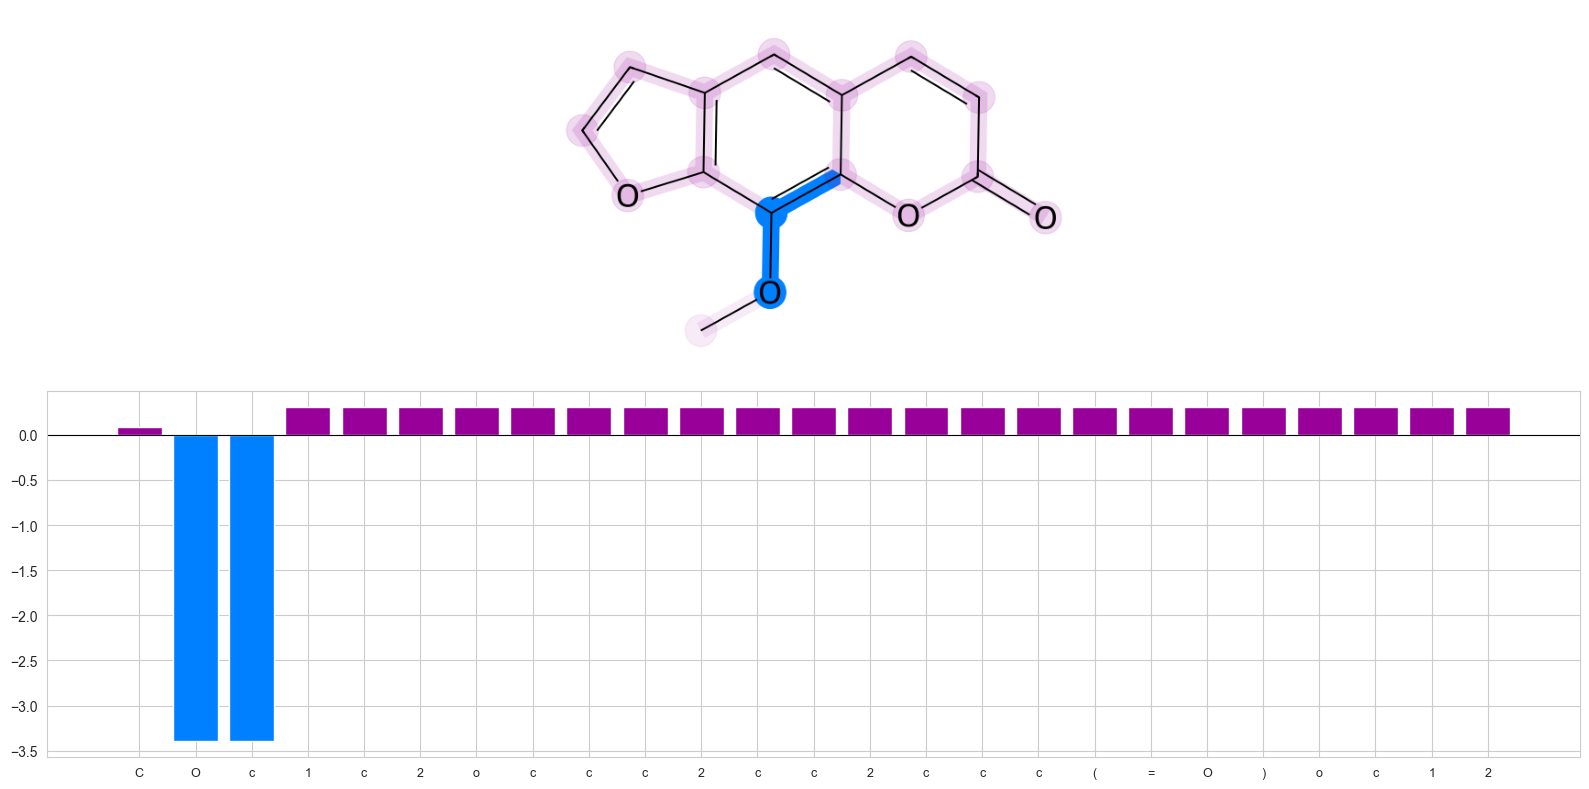

{'smiles': 'COC1=C2C(=CC3=C1OC=C3)C=CC(=O)O2',
 'tokens': ['C',
  'O',
  'c',
  '1',
  'c',
  '2',
  'o',
  'c',
  'c',
  'c',
  '2',
  'c',
  'c',
  '2',
  'c',
  'c',
  'c',
  '(',
  '=',
  'O',
  ')',
  'o',
  'c',
  '1',
  '2'],
 'atom_scores': array([ 0.20950879, -2.64323418, -2.64323418,  0.39053535,  0.39053535,
         0.39053535,  0.39053535,  0.39053535,  0.39053535,  0.39053535,
         0.39053535,  0.39053535,  0.39053535,  0.39053535,  0.39053535,
         0.39053535]),
 'token_scores': array([ 0.08387326, -3.38801459, -3.38801459,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891]),
 'base_atom_pred': 0.45688378632710863,
 'base_token_pred': 0.45688378632710863}

In [37]:
numeric_cols = [c for c in X_train.columns if X_train[c].nunique() > 10]
trained_columns = gb_lasso_metrics["Top_Features"]

result = run_xsmiles_pipeline(
    model=gb_lasso_model,
    smiles=dataset_ok.loc[5, "SMILES code"],
    train_medians=train_medians,
    iqr_limits=iqr_limits,
    numeric_cols=numeric_cols,
    trained_columns=trained_columns
)

result